## Generative AI 

## Transformer & LSTM Implementation for Machine Translation

#### Importing Libraries

In [1]:
import os
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, decoders, processors
from tokenizers.normalizers import NFD, Lowercase, StripAccents, Sequence
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
import torch
import torch.nn as nn
import math
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from rouge import Rouge

#### Loading Dataset + Preprocessing it

In [13]:
import os
import nltk
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents, Sequence
nltk.download('punkt')

# Step 1: Load your text data
data_dir = 'q1_data'
raw_data = {'english': {}, 'urdu': {}}
file_map = {'bible': {}, 'quran': {}}

# Define a function to correctly identify English and Urdu files
def identify_language(filename):
    if filename in ['Bible-EN', 'Quran-EN']:
        return 'english'
    elif filename in ['Bible-UR', 'Quran-UR']:
        return 'urdu'
    elif filename in ['Bible-UR-normalized', 'Quran-UR-normalized']:
        return 'urdu'
    elif filename.endswith('.en'):
        return 'english'
    elif filename.endswith('.ur'):
        return 'urdu'
    else:
        return None

# Define a simple Urdu sentence splitter
def split_sentences(text, lang='english'):
    if lang == 'english':
        return nltk.sent_tokenize(text)
    else:
        # Rough Urdu splitting
        text = text.replace('؟', '.').replace('۔', '.').replace('!', '.')
        return [s.strip() for s in text.split('.') if s.strip()]

# Load Bible and Quran data
for category in ['bible', 'quran']:
    folder_path = os.path.join(data_dir, category)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

        lang = identify_language(filename)
        
        if lang:
            raw_data[lang][filename] = split_sentences(content, lang=lang)
            file_map[category][filename] = lang
        else:
            print(f"Unrecognized file: {filename}")

# Step 2: Write raw corpora for training BPE
os.makedirs('tokenizer_corpus', exist_ok=True)

# Flatten all sentences into one file for tokenizer training
with open('tokenizer_corpus/english.txt', 'w', encoding='utf-8') as f:
    all_english_sentences = sum(raw_data['english'].values(), [])
    f.write('\n'.join(all_english_sentences))

with open('tokenizer_corpus/urdu.txt', 'w', encoding='utf-8') as f:
    all_urdu_sentences = sum(raw_data['urdu'].values(), [])
    f.write('\n'.join(all_urdu_sentences))

# Step 3: Define BPE tokenizer training function
def train_bpe_tokenizer(file_path, vocab_size=8000):
    tokenizer = Tokenizer(models.BPE())
    tokenizer.normalizer = Sequence([NFD(), Lowercase(), StripAccents()])
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer.decoder = decoders.BPEDecoder()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
    tokenizer.train([file_path], trainer)
    return tokenizer

# Step 4: Train tokenizers
english_tokenizer = train_bpe_tokenizer("tokenizer_corpus/english.txt")
urdu_tokenizer = train_bpe_tokenizer("tokenizer_corpus/urdu.txt")

# Step 5: Align English–Urdu sentence pairs
aligned_sentence_pairs = []

for category in ['bible', 'quran']:
    files = list(file_map[category].keys())
    eng_files = [f for f in files if file_map[category][f] == 'english']
    urd_files = [f for f in files if file_map[category][f] == 'urdu']

    for eng_file, urd_file in zip(sorted(eng_files), sorted(urd_files)):
        eng_sentences = raw_data['english'][eng_file]
        urd_sentences = raw_data['urdu'][urd_file]

        min_len = min(len(eng_sentences), len(urd_sentences))

        for i in range(min_len):
            eng_sent = eng_sentences[i]
            urd_sent = urd_sentences[i]

            if len(eng_sent.split()) < 5 or len(urd_sent.split()) < 5:
                continue
            if len(eng_sent.split()) > 50 or len(urd_sent.split()) > 50:
                continue

            aligned_sentence_pairs.append((eng_sent, urd_sent))

print(f"\nTotal Aligned Sentence Pairs: {len(aligned_sentence_pairs)}")

# Step 6: Tokenize aligned sentence pairs
def tokens_to_ids(tokenizer, tokens):
    return [tokenizer.token_to_id("[CLS]")] + \
           [tokenizer.token_to_id(t) for t in tokens if tokenizer.token_to_id(t) is not None] + \
           [tokenizer.token_to_id("[SEP]")]

tokenized_pairs = []

for eng_sent, urd_sent in aligned_sentence_pairs:
    eng_encoded = english_tokenizer.encode(eng_sent)
    urd_encoded = urdu_tokenizer.encode(urd_sent)
    src_ids = tokens_to_ids(english_tokenizer, eng_encoded.tokens)
    tgt_ids = tokens_to_ids(urdu_tokenizer, urd_encoded.tokens)
    tokenized_pairs.append((src_ids, tgt_ids))

# Step 7: Get Vocab Sizes
src_vocab_size = english_tokenizer.get_vocab_size()
tgt_vocab_size = urdu_tokenizer.get_vocab_size()

print("Source Vocab Size (English):", src_vocab_size)
print("Target Vocab Size (Urdu):", tgt_vocab_size)
print("Total Tokenized Sentence Pairs:", len(tokenized_pairs))

# Step 8: Sample
print("\nSample English Sentence:", aligned_sentence_pairs[0][0])
print("Sample Urdu Sentence:", aligned_sentence_pairs[0][1])
print("Sample English Token IDs:", tokenized_pairs[0][0][:20])
print("Sample Urdu Token IDs:", tokenized_pairs[0][1][:20])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Total Aligned Sentence Pairs: 15072
Source Vocab Size (English): 8000
Target Vocab Size (Urdu): 8000
Total Tokenized Sentence Pairs: 15072

Sample English Sentence: ﻿The book of the generation of Jesus Christ , the son of David , the son of Abraham .
Sample Urdu Sentence: ﻿یسُوع مسیح ابن داود ابن ابرہام کا نسب نامہ
ابراہام سے اِضحاق پیدا ہُوا اور اِضحاق سے یعقوب پیدا ہُوا اور یعقوب سے یہوداہ اور اس کے بھائی پیدا ہوئے
Sample English Token IDs: [2, 49, 51, 398, 64, 51, 2428, 64, 291, 422, 10, 51, 379, 64, 1475, 10, 51, 379, 64, 705]
Sample Urdu Token IDs: [2, 77, 276, 373, 1030, 1258, 1030, 1475, 103, 5183, 2183, 5621, 88, 3029, 345, 274, 81, 3029, 88, 1072]


### Transformer Model

In [14]:
import torch
import torch.nn as nn
import math

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

# Scaled Dot-Product Attention
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    attn = torch.softmax(scores, dim=-1)
    output = torch.matmul(attn, v)
    return output, attn

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model):
        super().__init__()
        assert d_model % heads == 0, "d_model must be divisible by heads"

        self.d_model = d_model
        self.heads = heads
        self.d_k = d_model // heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x, y=None, mask=None):
        if y is None:
            y = x

        B, L_x, _ = x.size()
        L_y = y.size(1)

        q = self.q_linear(x).view(B, L_x, self.heads, self.d_k).transpose(1, 2)
        k = self.k_linear(y).view(B, L_y, self.heads, self.d_k).transpose(1, 2)
        v = self.v_linear(y).view(B, L_y, self.heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            mask = mask.unsqueeze(1)  # For multi-heads
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        context = torch.matmul(attn, v)

        context = context.transpose(1, 2).contiguous().view(B, L_x, self.d_model)
        out = self.fc_out(context)
        return out

# Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.net(x)

# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = x + self.dropout(self.attn(self.norm1(x), mask=mask))
        x = x + self.dropout(self.ff(self.norm2(x)))
        return x

# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(heads, d_model)
        self.cross_attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
        x = x + self.dropout(self.self_attn(self.norm1(x), mask=tgt_mask))
        x = x + self.dropout(self.cross_attn(self.norm2(x), y=enc_out, mask=src_mask))
        x = x + self.dropout(self.ff(self.norm3(x)))
        return x

# Encoder
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, d_ff, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, heads, d_ff, dropout) for _ in range(N)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, src, mask=None):
        x = self.embed(src)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# Decoder
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, d_ff, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads, d_ff, dropout) for _ in range(N)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tgt, enc_out, src_mask=None, tgt_mask=None):
        x = self.embed(tgt)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_out, src_mask, tgt_mask)
        return self.norm(x)

# Full Transformer Model
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, N=6, heads=8, d_ff=2048, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, N, heads, d_ff, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, N, heads, d_ff, dropout)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_out = self.encoder(src, src_mask)
        dec_out = self.decoder(tgt, enc_out, src_mask, tgt_mask)
        out = self.fc_out(dec_out)
        return out


In [15]:
# STEP 9: Dataset Preparation and Hyperparameter Configuration
# Hyperparameter configuration
config = {
    'd_model': 256,          # Reduced from 512 for efficiency
    'n_layers': 4,           # Reduced from 6
    'heads': 8,
    'd_ff': 1024,            # Reduced from 2048
    'dropout': 0.1,
    'batch_size': 32,
    'lr': 0.0001,            # Lower learning rate
    'epochs': 30,
    'max_seq_len': 100,      # Maximum sequence length
    'warmup_steps': 4000,    # For learning rate scheduling
    'print_every': 50,
    'label_smoothing': 0.1,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

class TranslationDataset(Dataset):
    def __init__(self, pairs, src_pad_idx, tgt_pad_idx, split='train'):
        self.pairs = pairs
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.split = split  # 'train', 'val', or 'test'
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        return torch.LongTensor(src), torch.LongTensor(tgt)


In [16]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Padding values
src_pad_idx = english_tokenizer.token_to_id("[PAD]")
tgt_pad_idx = urdu_tokenizer.token_to_id("[PAD]")

# Define collate function for padding and truncation
def collate_fn(batch, src_pad_idx, tgt_pad_idx):
    src_batch, tgt_batch = zip(*batch)
    
    # Truncate sequences to max_seq_len
    src_batch = [seq[:config['max_seq_len']] for seq in src_batch]
    tgt_batch = [seq[:config['max_seq_len']] for seq in tgt_batch]
    
    # Pad sequences
    src_batch = pad_sequence(src_batch, padding_value=src_pad_idx, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=tgt_pad_idx, batch_first=True)
    
    return src_batch, tgt_batch

# Train-test split
train_pairs, val_pairs = train_test_split(tokenized_pairs, test_size=0.1, random_state=42)
train_pairs, test_pairs = train_test_split(train_pairs, test_size=0.2, random_state=42)

# Dataset and DataLoader
train_dataset = TranslationDataset(train_pairs, src_pad_idx, tgt_pad_idx, split='train')
val_dataset = TranslationDataset(val_pairs, src_pad_idx, tgt_pad_idx, split='val')
test_dataset = TranslationDataset(test_pairs, src_pad_idx, tgt_pad_idx, split='test')

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], collate_fn=lambda batch: collate_fn(batch, src_pad_idx, tgt_pad_idx))
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], collate_fn=lambda batch: collate_fn(batch, src_pad_idx, tgt_pad_idx))
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], collate_fn=lambda batch: collate_fn(batch, src_pad_idx, tgt_pad_idx))

In [17]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.util import ngrams

def lcs(X, Y):
    # Helper function for ROUGE-L
    m = len(X)
    n = len(Y)
    L = [[0] * (n+1) for i in range(m+1)]
    for i in range(m):
        for j in range(n):
            if X[i] == Y[j]:
                L[i+1][j+1] = L[i][j] + 1
            else:
                L[i+1][j+1] = max(L[i+1][j], L[i][j+1])
    return L[m][n]

def rouge_l_score(pred_tokens, ref_tokens):
    lcs_len = lcs(pred_tokens, ref_tokens)
    precision = lcs_len / len(pred_tokens) if pred_tokens else 0
    recall = lcs_len / len(ref_tokens) if ref_tokens else 0
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = (2 * precision * recall) / (precision + recall)
    return f1

def evaluate_bleu_rouge_nltk(model, loader, english_tokenizer, urdu_tokenizer, device, tgt_pad_idx):
    model.eval()
    smooth_fn = SmoothingFunction().method4
    bleu_scores = []
    rouge_l_scores = []
    
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            output = model(src, tgt_input)
            output_ids = output.argmax(dim=-1)
            
            for pred, target in zip(output_ids, tgt[:, 1:]):
                pred_tokens = [urdu_tokenizer.id_to_token(id.item()) for id in pred if id.item() != tgt_pad_idx]
                target_tokens = [urdu_tokenizer.id_to_token(id.item()) for id in target if id.item() != tgt_pad_idx]
                
                bleu = sentence_bleu(
                    [target_tokens], pred_tokens, smoothing_function=smooth_fn
                )
                rouge_l = rouge_l_score(pred_tokens, target_tokens)
                
                bleu_scores.append(bleu)
                rouge_l_scores.append(rouge_l)
    
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)
    return avg_bleu, avg_rouge_l


In [18]:
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR 

# Learning rate scheduler function
def lr_schedule(step):
    d_model = config['d_model']
    warmup_steps = config['warmup_steps']
    step = max(step, 1)  # Prevent step=0 to avoid division by zero
    return (d_model ** -0.5) * min(step ** -0.5, step * warmup_steps ** -1.5)

# Model Initialization

model = Transformer(
    src_vocab_size, 
    tgt_vocab_size,
    d_model=config['d_model'],
    N=config['n_layers'],
    heads=config['heads'],
    d_ff=config['d_ff'],
    dropout=config['dropout']
)
model.to(config['device'])

class LabelSmoothingLoss(nn.Module):
    def __init__(self, pad_idx, smoothing=0.1, reduction='mean'):
        super().__init__()
        self.pad_idx = pad_idx
        self.smoothing = smoothing
        self.reduction = reduction

    def forward(self, pred, target):
        n_classes = pred.size(-1)
        log_pred = F.log_softmax(pred, dim=-1)
        non_pad_mask = (target != self.pad_idx)
        
        # Calculate smoothed target distribution
        with torch.no_grad():
            smooth_target = torch.full_like(log_pred, self.smoothing / (n_classes - 1))
            smooth_target.scatter_(-1, target.unsqueeze(-1), 1 - self.smoothing)
            smooth_target.masked_fill_(~non_pad_mask.unsqueeze(-1), 0)  # Zero out padding
        
        # KL divergence loss
        loss = -(smooth_target * log_pred).sum(dim=-1)
        loss = loss.masked_fill(~non_pad_mask, 0)  # Ignore padding
        
        if self.reduction == 'mean':
            return loss.sum() / non_pad_mask.sum()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], betas=(0.9, 0.98), weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])
criterion = LabelSmoothingLoss(tgt_pad_idx, smoothing=config['label_smoothing'])
gradient_accumulation_steps = 4
# Early stopping settings
patience, trials = 5, 0  
best_val_loss = float('inf')
clip_value = 1.0
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

for epoch in range(config['epochs']):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    
    for step, (src, tgt) in enumerate(train_loader):
        src, tgt = src.to(config['device']), tgt.to(config['device'])
        tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]

        output = model(src, tgt_input)
        loss = criterion(output.view(-1, tgt_vocab_size), tgt_output.contiguous().view(-1))
        loss.backward()

        # Gradient accumulation
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    
    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(config['device']), tgt.to(config['device'])
            tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]
            output = model(src, tgt_input)
            loss = criterion(output.view(-1, tgt_vocab_size), tgt_output.contiguous().view(-1))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    
    # Log losses
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print("Early stopping triggered.")
            break
    
    # Learning rate scheduler step
    scheduler.step()
    
    # After validation loss calculation
    avg_bleu, avg_rouge_l = evaluate_bleu_rouge_nltk(model, val_loader, english_tokenizer, urdu_tokenizer, config['device'], tgt_pad_idx)
    print(f"BLEU Score: {avg_bleu:.4f} | ROUGE-L Score: {avg_rouge_l:.4f}")

# Test evaluation after training
model.load_state_dict(torch.load("best_model.pt"))
test_loss = 0
model.eval()
with torch.no_grad():
    for src, tgt in test_loader:
        src, tgt = src.to(config['device']), tgt.to(config['device'])
        tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]
        output = model(src, tgt_input)
        loss = criterion(output.view(-1, tgt_vocab_size), tgt_output.contiguous().view(-1))
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Final Test Loss: {avg_test_loss:.4f}")

Epoch 1 | Train Loss: 7.5647 | Val Loss: 6.7014
BLEU Score: 0.0087 | ROUGE-L Score: 0.0751
Epoch 2 | Train Loss: 6.3374 | Val Loss: 6.0659
BLEU Score: 0.0168 | ROUGE-L Score: 0.1541
Epoch 3 | Train Loss: 5.8271 | Val Loss: 5.6431
BLEU Score: 0.0233 | ROUGE-L Score: 0.1987
Epoch 4 | Train Loss: 5.4067 | Val Loss: 5.2268
BLEU Score: 0.0358 | ROUGE-L Score: 0.2475
Epoch 5 | Train Loss: 5.0202 | Val Loss: 4.8731
BLEU Score: 0.0506 | ROUGE-L Score: 0.2859
Epoch 6 | Train Loss: 4.6858 | Val Loss: 4.5686
BLEU Score: 0.0672 | ROUGE-L Score: 0.3158
Epoch 7 | Train Loss: 4.3878 | Val Loss: 4.2914
BLEU Score: 0.0853 | ROUGE-L Score: 0.3418
Epoch 8 | Train Loss: 4.1089 | Val Loss: 4.0306
BLEU Score: 0.1050 | ROUGE-L Score: 0.3660
Epoch 9 | Train Loss: 3.8577 | Val Loss: 3.7994
BLEU Score: 0.1250 | ROUGE-L Score: 0.3878
Epoch 10 | Train Loss: 3.6360 | Val Loss: 3.5891
BLEU Score: 0.1457 | ROUGE-L Score: 0.4080
Epoch 11 | Train Loss: 3.4329 | Val Loss: 3.4071
BLEU Score: 0.1659 | ROUGE-L Score: 0.42

C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\1860115296.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


Final Test Loss: 2.4103


### LSTM Model

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.nn.utils.rnn import pad_sequence


In [22]:
# Encoder LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

# Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Parameter(torch.rand(hid_dim))

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[1]
        hidden = hidden[-1].unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        energy = energy.permute(0, 2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        attn_weights = torch.bmm(v, energy).squeeze(1)
        return torch.softmax(attn_weights, dim=1)

# Decoder LSTM + Attention
class DecoderLSTM(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = attention
        self.lstm = nn.LSTM(hid_dim + emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim * 2, output_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        attn_weights = self.attention(hidden, encoder_outputs)
        attn_weights = attn_weights.unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        prediction = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1)), dim=1))
        return prediction, hidden, cell

# Full Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src)
        
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1
        
        return outputs


In [23]:
INPUT_DIM = src_vocab_size
OUTPUT_DIM = tgt_vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(HID_DIM)
enc = EncoderLSTM(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = DecoderLSTM(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)

model_lstm = Seq2Seq(enc, dec, config['device']).to(config['device'])

optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_pad_idx)


In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    mins = int(elapsed_time / 60)
    secs = int(elapsed_time - (mins * 60))
    return mins, secs

n_epochs = 30
best_valid_loss = float('inf')

for epoch in range(n_epochs):

    start_time = time.time()

    model_lstm.train()
    train_loss = 0

    for src, tgt in train_loader:
        src, tgt = src.to(config['device']), tgt.to(config['device'])
        optimizer.zero_grad()
        
        output = model_lstm(src, tgt)

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), max_norm=1)
        optimizer.step()

        train_loss += loss.item()

    model_lstm.eval()
    valid_loss = 0

    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(config['device']), tgt.to(config['device'])
            output = model_lstm(src, tgt, 0)  # no teacher forcing
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            tgt = tgt[:, 1:].reshape(-1)
            loss = criterion(output, tgt)
            valid_loss += loss.item()

    end_time = time.time()

    train_loss /= len(train_loader)
    valid_loss /= len(val_loader)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_lstm.state_dict(), 'best-lstm-model.pt')


Epoch: 01 | Time: 31m 13s
	Train Loss: 6.069
	 Val. Loss: 6.123
Epoch: 02 | Time: 33m 30s
	Train Loss: 5.677
	 Val. Loss: 6.080
Epoch: 03 | Time: 37m 9s
	Train Loss: 5.456
	 Val. Loss: 6.108
Epoch: 04 | Time: 37m 28s
	Train Loss: 5.318
	 Val. Loss: 6.102
Epoch: 05 | Time: 30m 55s
	Train Loss: 5.219
	 Val. Loss: 6.150
Epoch: 06 | Time: 29m 6s
	Train Loss: 5.110
	 Val. Loss: 6.241
Epoch: 07 | Time: 31m 23s
	Train Loss: 5.028
	 Val. Loss: 6.418
Epoch: 08 | Time: 38m 49s
	Train Loss: 4.945
	 Val. Loss: 6.253
Epoch: 09 | Time: 39m 3s
	Train Loss: 4.865
	 Val. Loss: 6.278
Epoch: 10 | Time: 33m 13s
	Train Loss: 4.796
	 Val. Loss: 6.271
Epoch: 11 | Time: 32m 33s
	Train Loss: 4.726
	 Val. Loss: 6.360
Epoch: 12 | Time: 32m 50s
	Train Loss: 4.638
	 Val. Loss: 6.414
Epoch: 13 | Time: 38m 50s
	Train Loss: 4.573
	 Val. Loss: 6.480
Epoch: 14 | Time: 40m 52s
	Train Loss: 4.528
	 Val. Loss: 6.474
Epoch: 15 | Time: 35m 50s
	Train Loss: 4.483
	 Val. Loss: 6.442
Epoch: 16 | Time: 29m 8s
	Train Loss: 4.448

In [25]:
# After training:
model_lstm.load_state_dict(torch.load('best-lstm-model.pt'))
bleu_score, rouge_l_score = evaluate_bleu_rouge_nltk(model_lstm, test_loader, english_tokenizer, urdu_tokenizer, config['device'], tgt_pad_idx)
print(f"Test BLEU Score: {bleu_score:.4f}")
print(f"Test ROUGE-L Score: {rouge_l_score:.4f}")

C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\636363076.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_lstm.load_state_dict(torch.load('best-lstm-model.pt'))


Test BLEU Score: 0.0137
Test ROUGE-L Score: 0.1155


#### Visualizing Train+Val Losses

In [33]:
# Losses for Transformer
transformer_train_losses = [7.56, 6.33, 5.82, 5.40, 5.02, 4.68, 4.38, 4.10, 3.85, 3.63, 3.43, 3.25, 3.09, 2.96, 2.84, 2.74, 2.66, 2.59, 2.53, 2.47, 2.43, 2.40, 2.37, 2.35, 2.34, 2.33, 2.32, 2.31, 2.31, 2.31]
transformer_val_losses = [6.70, 6.06, 5.64, 5.22, 4.87, 4.56, 4.29, 4.03, 3.79, 3.58, 3.40, 3.24, 3.10, 2.98, 2.87, 2.79, 2.71, 2.65, 2.60, 2.55, 2.52, 2.49, 2.47, 2.45, 2.44, 2.43, 2.43, 2.42, 2.42, 2.42]

# Losses for LSTM
lstm_train_losses = [6.06, 6.03, 5.67, 5.45, 5.31, 5.21, 5.11, 5.02, 4.95, 4.86, 4.76, 4.72, 4.63, 4.57, 4.52, 4.48, 4.44, 4.41, 4.42, 4.35, 4.31, 4.29, 4.26, 4.19, 4.16, 4.15, 4.11, 4.06, 4.03, 4.03]
lstm_val_losses = [6.12, 6.08, 6.10, 6.10, 6.15, 6.24, 6.41, 6.25, 6.27, 6.27, 6.36, 6.41, 6.48, 6.47, 6.44, 6.46, 6.59, 6.65, 6.85, 6.68, 6.92, 6.84, 6.96, 7.09, 7.05, 6.98, 7.17, 7.06, 7.25, 7.15]


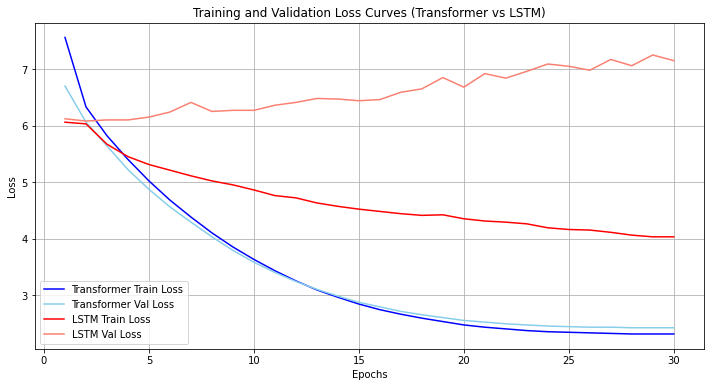

In [34]:
import matplotlib.pyplot as plt

epochs = range(1, len(transformer_train_losses) + 1)

plt.figure(figsize=(12,6))

# Transformer
plt.plot(epochs, transformer_train_losses, label='Transformer Train Loss', color='blue')
plt.plot(epochs, transformer_val_losses, label='Transformer Val Loss', color='skyblue')

# LSTM
plt.plot(epochs, lstm_train_losses, label='LSTM Train Loss', color='red')
plt.plot(epochs, lstm_val_losses, label='LSTM Val Loss', color='salmon')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves (Transformer vs LSTM)')
plt.legend()
plt.grid(True)
plt.show()


#### Attention Visualization

In [39]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model):
        super().__init__()
        assert d_model % heads == 0, "d_model must be divisible by heads"

        self.d_model = d_model
        self.heads = heads
        self.d_k = d_model // heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(0.1)
        self.attn_weights = None  # <--- ADD THIS

    def forward(self, x, y=None, mask=None):
        if y is None:
            y = x

        B, L_x, _ = x.size()
        L_y = y.size(1)

        q = self.q_linear(x).view(B, L_x, self.heads, self.d_k).transpose(1, 2)
        k = self.k_linear(y).view(B, L_y, self.heads, self.d_k).transpose(1, 2)
        v = self.v_linear(y).view(B, L_y, self.heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = torch.softmax(scores, dim=-1)
        self.attn_weights = attn.detach().cpu()  # <--- STORE ATTENTION
        attn = self.dropout(attn)

        context = torch.matmul(attn, v)
        context = context.transpose(1, 2).contiguous().view(B, L_x, self.d_model)
        out = self.fc_out(context)
        return out

# import torch
# import torch.nn as nn
# import math

# Positional Encoding
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super().__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))

#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)

#         self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

#     def forward(self, x):
#         x = x + self.pe[:, :x.size(1), :].to(x.device)
#         return x

# # Scaled Dot-Product Attention
# def scaled_dot_product(q, k, v, mask=None):
#     d_k = q.size(-1)
#     scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

#     if mask is not None:
#         scores = scores.masked_fill(mask == 0, float('-inf'))

#     attn = torch.softmax(scores, dim=-1)
#     output = torch.matmul(attn, v)
#     return output, attn

# Feed Forward Network
# class FeedForward(nn.Module):
#     def __init__(self, d_model, d_ff, dropout=0.1):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(d_model, d_ff),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(d_ff, d_model)
#         )

#     def forward(self, x):
#         return self.net(x)

# Encoder Layer
# class EncoderLayer(nn.Module):
#     def __init__(self, d_model, heads, d_ff, dropout=0.1):
#         super().__init__()
#         self.attn = MultiHeadAttention(heads, d_model)
#         self.ff = FeedForward(d_model, d_ff, dropout)

#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, mask=None):
#         x = x + self.dropout(self.attn(self.norm1(x), mask=mask))
#         x = x + self.dropout(self.ff(self.norm2(x)))
#         return x

# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(heads, d_model)
        self.cross_attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
        x = x + self.dropout(self.self_attn(self.norm1(x), mask=tgt_mask))
        cross_output = self.cross_attn(self.norm2(x), y=enc_out, mask=src_mask)
        self.attn_weights = self.cross_attn.attn_weights  # <--- ADD THIS
        x = x + self.dropout(cross_output)
        x = x + self.dropout(self.ff(self.norm3(x)))
        return x


# Encoder
# class Encoder(nn.Module):
#     def __init__(self, vocab_size, d_model, N, heads, d_ff, dropout=0.1):
#         super().__init__()
#         self.embed = nn.Embedding(vocab_size, d_model)
#         self.positional_encoding = PositionalEncoding(d_model)
#         self.layers = nn.ModuleList([EncoderLayer(d_model, heads, d_ff, dropout) for _ in range(N)])
#         self.norm = nn.LayerNorm(d_model)

#     def forward(self, src, mask=None):
#         x = self.embed(src)
#         x = self.positional_encoding(x)
#         for layer in self.layers:
#             x = layer(x, mask)
#         return self.norm(x)

# Decoder
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, d_ff, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads, d_ff, dropout) for _ in range(N)])
        self.norm = nn.LayerNorm(d_model)
        self.attn_maps = None  # ← ADD THIS HERE (ensures it exists even before forward)

    def forward(self, tgt, enc_out, src_mask=None, tgt_mask=None):
        x = self.embed(tgt)
        x = self.positional_encoding(x)

        self.attn_maps = []  # ← Reset this inside forward

        for layer in self.layers:
            x = layer(x, enc_out, src_mask, tgt_mask)
            self.attn_maps.append(layer.attn_weights)

        return self.norm(x)



# # Full Transformer Model
# class Transformer(nn.Module):
#     def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, N=6, heads=8, d_ff=2048, dropout=0.1):
#         super().__init__()
#         self.encoder = Encoder(src_vocab_size, d_model, N, heads, d_ff, dropout)
#         self.decoder = Decoder(tgt_vocab_size, d_model, N, heads, d_ff, dropout)
#         self.fc_out = nn.Linear(d_model, tgt_vocab_size)

#     def forward(self, src, tgt, src_mask=None, tgt_mask=None):
#         enc_out = self.encoder(src, src_mask)
#         dec_out = self.decoder(tgt, enc_out, src_mask, tgt_mask)
#         out = self.fc_out(dec_out)
#         return out


C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\2526784739.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("best_model.pt", map_locat

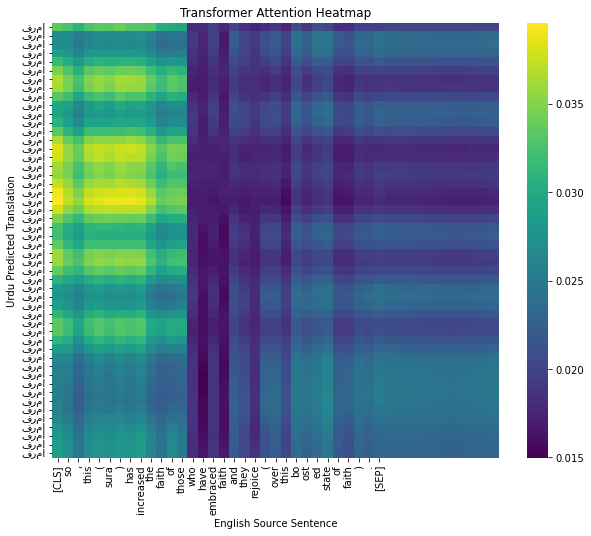

In [48]:
# ======= IMPORTS =======
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ======= LOAD MODEL MATCHING YOUR CONFIG =======
model2 = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=config['d_model'],       # 256
    N=config['n_layers'],            # 4
    heads=config['heads'],           # 8
    d_ff=config['d_ff'],             # 1024
    dropout=config['dropout']        # 0.1
).to(config['device'])

model2.load_state_dict(torch.load("best_model.pt", map_location=config['device']))
model2.eval()

# ======= TRANSLATE + GET ATTENTION =======
def translate_with_attention(model, src_tensor, src_tokenizer, tgt_tokenizer, max_len=50):
    model.eval()
    src_tensor = src_tensor.unsqueeze(0).to(config['device'])  # (1, seq_len)
    memory = model.encoder(src_tensor)

    tgt_input = torch.tensor([[tgt_tokenizer.token_to_id("[CLS]")]]).to(config['device'])
    output_tokens = []

    for _ in range(max_len):
        output = model.decoder(tgt_input, memory)
        output = model.fc_out(output)
        next_token = output[:, -1, :].argmax(-1)
        output_tokens.append(next_token.item())
        tgt_input = torch.cat((tgt_input, next_token.unsqueeze(0)), dim=1)

        if next_token.item() == tgt_tokenizer.token_to_id("[SEP]"):
            break

    # Get attention weights from last decoder layer
    attn_weights = model.decoder.attn_maps[-1]  # (1, heads, tgt_len, src_len)
    attn_avg = attn_weights.mean(dim=1).squeeze(0).cpu().detach().numpy()  # (tgt_len, src_len)

    return output_tokens, attn_avg

# ======= PLOT HEATMAP =======
def plot_attention(attention_matrix, source_tokens, target_tokens, title="Transformer Attention Heatmap"):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(attention_matrix, xticklabels=source_tokens, yticklabels=target_tokens, cmap="viridis")
    plt.xlabel("English Source Sentence")
    plt.ylabel("Urdu Predicted Translation")
    plt.title(title)
    plt.show()

# ======= RUN ON ONE TEST EXAMPLE =======
sample_src, _ = next(iter(test_loader))  # one batch
sample_src = sample_src[0]               # take first sentence

output_ids, attn_matrix = translate_with_attention(model2, sample_src, english_tokenizer, urdu_tokenizer)

src_tokens = [english_tokenizer.id_to_token(idx) for idx in sample_src.cpu().numpy() if idx != src_pad_idx]
pred_tokens = [urdu_tokenizer.id_to_token(idx) for idx in output_ids if idx not in [tgt_pad_idx, urdu_tokenizer.token_to_id("[SEP]")]]

plot_attention(attn_matrix, src_tokens, pred_tokens)


### GUI

In [50]:
import torch

# Load the transformer model
transformer_model = torch.load('best_model.pt')

# Load the LSTM model
lstm_model = torch.load('best-lstm-model.pt')


C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\423287689.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_model = torch.load('best_model.pt')
C:\Users\DELL\

In [ ]:
import tkinter as tk
from tkinter import ttk, scrolledtext, messagebox
import torch
from torch.nn.utils.rnn import pad_sequence
import math
import os
from tokenizers import Tokenizer

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # Shape: (1, max_len, d_model)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :].to(x.device)

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model):
        super().__init__()
        assert d_model % heads == 0, "d_model must be divisible by heads"
        self.d_model = d_model
        self.heads = heads
        self.d_k = d_model // heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, y=None, mask=None):
        if y is None: y = x
        B, L_x, _ = x.size()
        L_y = y.size(1)
        q = self.q_linear(x).view(B, L_x, self.heads, self.d_k).transpose(1, 2)
        k = self.k_linear(y).view(B, L_y, self.heads, self.d_k).transpose(1, 2)
        v = self.v_linear(y).view(B, L_y, self.heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        context = torch.matmul(attn, v)
        context = context.transpose(1, 2).contiguous().view(B, L_x, self.d_model)
        return self.fc_out(context)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.net(x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = x + self.dropout(self.attn(self.norm1(x), mask=mask))
        x = x + self.dropout(self.ff(self.norm2(x)))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(heads, d_model)
        self.cross_attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
        x = x + self.dropout(self.self_attn(self.norm1(x), mask=tgt_mask))
        x = x + self.dropout(self.cross_attn(self.norm2(x), y=enc_out, mask=src_mask))
        x = x + self.dropout(self.ff(self.norm3(x)))
        return x

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, d_ff, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, heads, d_ff, dropout) for _ in range(N)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, src, mask=None):
        x = self.embed(src)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, d_ff, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads, d_ff, dropout) for _ in range(N)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tgt, enc_out, src_mask=None, tgt_mask=None):
        x = self.embed(tgt)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_out, src_mask, tgt_mask)
        return self.norm(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, N=6, heads=8, d_ff=2048, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, N, heads, d_ff, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, N, heads, d_ff, dropout)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_out = self.encoder(src, src_mask)
        dec_out = self.decoder(tgt, enc_out, src_mask, tgt_mask)
        return self.fc_out(dec_out)

# LSTM Model Classes
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Parameter(torch.rand(hid_dim))

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[1]
        hidden = hidden[-1].unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        energy = energy.permute(0, 2, 1)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        attn_weights = torch.bmm(v, energy).squeeze(1)
        return torch.softmax(attn_weights, dim=1)

class DecoderLSTM(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = attention
        self.lstm = nn.LSTM(hid_dim + emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim * 2, output_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        attn_weights = self.attention(hidden, encoder_outputs)
        attn_weights = attn_weights.unsqueeze(1)
        context = torch.bmm(attn_weights, encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        prediction = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1)), dim=1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1
        
        return outputs

# Configuration
config = {
    'd_model': 256,
    'n_layers': 4,
    'heads': 8,
    'd_ff': 1024,
    'dropout': 0.1,
    'batch_size': 32,
    'max_seq_len': 100,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

class TranslationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("English to Urdu Translator")
        self.root.geometry("800x600")
        
        # Initialize tokenizers and models
        self.english_tokenizer = None
        self.urdu_tokenizer = None
        self.transformer_model = None
        self.lstm_model = None
        
        # Load tokenizers and models
        self.load_resources()
        
        # Create UI elements
        self.create_widgets()
        
        # Store conversation history
        self.conversation_history = []
    
    def load_resources(self):
        try:
            # Load tokenizers (you'll need to replace these paths with your actual tokenizer files)
#             self.english_tokenizer = Tokenizer.from_file("english_tokenizer.json")
#             self.urdu_tokenizer = Tokenizer.from_file("urdu_tokenizer.json")
            
#             # Get vocab sizes
#             src_vocab_size = self.english_tokenizer.get_vocab_size()
#             tgt_vocab_size = self.urdu_tokenizer.get_vocab_size()
            
            # Initialize and load Transformer model
            self.transformer_model = Transformer(
                src_vocab_size=src_vocab_size,
                tgt_vocab_size=tgt_vocab_size,
                d_model=config['d_model'],
                N=config['n_layers'],
                heads=config['heads'],
                d_ff=config['d_ff'],
                dropout=config['dropout']
            ).to(config['device'])
            self.transformer_model.load_state_dict(torch.load("best_model.pt", map_location=config['device']))
            self.transformer_model.eval()
            
            # Initialize and load LSTM model
            enc = EncoderLSTM(
                input_dim=src_vocab_size,
                emb_dim=256,
                hid_dim=512,
                n_layers=2,
                dropout=0.5
            )
            attn = Attention(512)
            dec = DecoderLSTM(
                output_dim=tgt_vocab_size,
                emb_dim=256,
                hid_dim=512,
                n_layers=2,
                dropout=0.5,
                attention=attn
            )
            self.lstm_model = Seq2Seq(enc, dec, config['device']).to(config['device'])
            self.lstm_model.load_state_dict(torch.load("best-lstm-model.pt", map_location=config['device']))
            self.lstm_model.eval()
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load resources: {str(e)}")
            self.root.destroy()
    
    def create_widgets(self):
        # Main frame
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Model selection
        model_frame = ttk.Frame(main_frame)
        model_frame.pack(fill=tk.X, pady=5)
        
        ttk.Label(model_frame, text="Model:").pack(side=tk.LEFT)
        self.model_var = tk.StringVar(value="transformer")
        ttk.Radiobutton(model_frame, text="Transformer", variable=self.model_var, value="transformer").pack(side=tk.LEFT, padx=5)
        ttk.Radiobutton(model_frame, text="LSTM", variable=self.model_var, value="lstm").pack(side=tk.LEFT, padx=5)
        
        # Conversation display
        self.conversation_text = scrolledtext.ScrolledText(
            main_frame, 
            wrap=tk.WORD, 
            font=('Arial', 12), 
            state='disabled'
        )
        self.conversation_text.pack(fill=tk.BOTH, expand=True, pady=10)
        
        # Configure tags for alignment
        self.conversation_text.tag_configure('left', justify='left')
        self.conversation_text.tag_configure('right', justify='right')
        self.conversation_text.tag_configure('bold', font=('Arial', 12, 'bold'))
        
        # Input frame
        input_frame = ttk.Frame(main_frame)
        input_frame.pack(fill=tk.X)
        
        self.input_entry = ttk.Entry(
            input_frame, 
            font=('Arial', 12)
        )
        self.input_entry.pack(side=tk.LEFT, fill=tk.X, expand=True, padx=(0, 5))
        self.input_entry.bind("<Return>", self.on_enter_pressed)
        
        translate_btn = ttk.Button(
            input_frame, 
            text="Translate", 
            command=self.translate_text
        )
        translate_btn.pack(side=tk.RIGHT)
        
        # Clear button
        clear_btn = ttk.Button(
            main_frame,
            text="Clear Conversation",
            command=self.clear_conversation
        )
        clear_btn.pack(pady=5)
    
    def on_enter_pressed(self, event):
        self.translate_text()
    
    def translate_text(self):
        input_text = self.input_entry.get().strip()
        if not input_text:
            return
        
        # Add user input to conversation
        self.add_to_conversation("You", input_text, align="left")
        self.input_entry.delete(0, tk.END)
        
        try:
            # Get translation
            translated_text = self.get_translation(input_text)
            
            # Add translation to conversation
            self.add_to_conversation("Translator", translated_text, align="right")
        except Exception as e:
            messagebox.showerror("Translation Error", f"Failed to translate: {str(e)}")
    
    def get_translation(self, text):
        # Tokenize input
        eng_encoded = self.english_tokenizer.encode(text)
        src_ids = [self.english_tokenizer.token_to_id("[CLS]")] + \
                 [self.english_tokenizer.token_to_id(t) for t in eng_encoded.tokens 
                  if self.english_tokenizer.token_to_id(t) is not None] + \
                 [self.english_tokenizer.token_to_id("[SEP]")]
        
        # Convert to tensor
        src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(config['device'])
        
        # Get model
        model = self.transformer_model if self.model_var.get() == "transformer" else self.lstm_model
        
        # Generate translation
        if self.model_var.get() == "transformer":
            # Transformer translation
            memory = model.encoder(src_tensor)
            tgt_input = torch.tensor([[self.urdu_tokenizer.token_to_id("[CLS]")]]).to(config['device'])
            
            output_tokens = []
            for _ in range(config['max_seq_len']):
                output = model.decoder(tgt_input, memory)
                output = model.fc_out(output)
                next_token = output[:, -1, :].argmax(-1)
                output_tokens.append(next_token.item())
                tgt_input = torch.cat((tgt_input, next_token.unsqueeze(0)), dim=1)
                
                if next_token.item() == self.urdu_tokenizer.token_to_id("[SEP]"):
                    break
        else:
            # LSTM translation
            encoder_outputs, hidden, cell = model.encoder(src_tensor)
            tgt_input = torch.tensor([[self.urdu_tokenizer.token_to_id("[CLS]")]]).to(config['device'])
            
            output_tokens = []
            for _ in range(config['max_seq_len']):
                output, hidden, cell = model.decoder(
                    tgt_input[:, -1], hidden, cell, encoder_outputs
                )
                next_token = output.argmax(-1)
                output_tokens.append(next_token.item())
                tgt_input = torch.cat((tgt_input, next_token.unsqueeze(0)), dim=1)
                
                if next_token.item() == self.urdu_tokenizer.token_to_id("[SEP]"):
                    break
        
        # Convert output tokens to text
        translated_text = " ".join(
            [self.urdu_tokenizer.id_to_token(idx) for idx in output_tokens 
             if idx not in [self.urdu_tokenizer.token_to_id("[PAD]"), 
                          self.urdu_tokenizer.token_to_id("[SEP]")]]
        )
        
        return translated_text
    
    def add_to_conversation(self, sender, text, align="left"):
        self.conversation_text.configure(state='normal')
        
        # Insert sender name
        self.conversation_text.insert(tk.END, f"{sender}:\n", ('bold', align))
        
        # Insert message text
        self.conversation_text.insert(tk.END, f"{text}\n\n", (align,))
        
        self.conversation_text.configure(state='disabled')
        self.conversation_text.see(tk.END)
        
        # Store in history
        self.conversation_history.append((sender, text, align))
    
    def clear_conversation(self):
        self.conversation_text.configure(state='normal')
        self.conversation_text.delete(1.0, tk.END)
        self.conversation_text.configure(state='disabled')
        self.conversation_history = []

if __name__ == "__main__":
    root = tk.Tk()
    app = TranslationApp(root)
    root.mainloop()

C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\2897147996.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.transformer_model.load_state_dict(torch.load("best_mod

In [53]:
# import tkinter as tk
# from tkinter import ttk, scrolledtext, messagebox
# import torch
# from torch.nn.utils.rnn import pad_sequence

# class TranslationApp:
#     def __init__(self, root):
#         self.root = root
#         self.root.title("English to Urdu Translator")
#         self.root.geometry("800x600")
        
#         # Load models (replace with your actual model loading code)
#         self.transformer_model = None
#         self.lstm_model = None
#         self.load_models()
        
#         # Create UI elements
#         self.create_widgets()
        
#         # Store conversation history
#         self.conversation_history = []
    
#     def load_models(self):
#         try:
#             # Load the transformer model
#             transformer_model = torch.load('best_model.pt')

#             # Load the LSTM model
#             lstm_model = torch.load('best-lstm-model.pt')
            
#             # For now, we'll just print a message
#             print("Models would be loaded here in a real implementation")
#         except Exception as e:
#             messagebox.showerror("Error", f"Failed to load models: {str(e)}")
    
#     def create_widgets(self):
#         # Main frame
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
        
#         # Model selection
#         model_frame = ttk.Frame(main_frame)
#         model_frame.pack(fill=tk.X, pady=5)
        
#         ttk.Label(model_frame, text="Model:").pack(side=tk.LEFT)
#         self.model_var = tk.StringVar(value="transformer")
#         ttk.Radiobutton(model_frame, text="Transformer", variable=self.model_var, value="transformer").pack(side=tk.LEFT, padx=5)
#         ttk.Radiobutton(model_frame, text="LSTM", variable=self.model_var, value="lstm").pack(side=tk.LEFT, padx=5)
        
#         # Conversation display
#         self.conversation_text = scrolledtext.ScrolledText(
#             main_frame, 
#             wrap=tk.WORD, 
#             font=('Arial', 12), 
#             state='disabled'
#         )
#         self.conversation_text.pack(fill=tk.BOTH, expand=True, pady=10)
        
#         # Input frame
#         input_frame = ttk.Frame(main_frame)
#         input_frame.pack(fill=tk.X)
        
#         self.input_entry = ttk.Entry(
#             input_frame, 
#             font=('Arial', 12)
#         )
#         self.input_entry.pack(side=tk.LEFT, fill=tk.X, expand=True, padx=(0, 5))
#         self.input_entry.bind("<Return>", self.on_enter_pressed)
        
#         translate_btn = ttk.Button(
#             input_frame, 
#             text="Translate", 
#             command=self.translate_text
#         )
#         translate_btn.pack(side=tk.RIGHT)
        
#         # Clear button
#         clear_btn = ttk.Button(
#             main_frame,
#             text="Clear Conversation",
#             command=self.clear_conversation
#         )
#         clear_btn.pack(pady=5)
    
#     def on_enter_pressed(self, event):
#         self.translate_text()
    
#     def translate_text(self):
#         input_text = self.input_entry.get().strip()
#         if not input_text:
#             return
        
#         # Add user input to conversation
#         self.add_to_conversation("You", input_text, align="left")
#         self.input_entry.delete(0, tk.END)
        
#         # Get translation (in a real app, this would use your actual model)
#         translated_text = self.get_translation(input_text)
        
#         # Add translation to conversation
#         self.add_to_conversation("Translator", translated_text, align="right")
    
# #     def get_translation(self, text):
# #         # In a real implementation, this would:
# #         # 1. Tokenize the input text using english_tokenizer
# #         # 2. Convert to tensor and move to device
# #         # 3. Run through the selected model (transformer or LSTM)
# #         # 4. Decode the output using urdu_tokenizer
# #         # 5. Return the translated text
        
# #         # For demonstration, we'll just return a placeholder
# #         model_type = self.model_var.get()
# #         if model_type == "transformer":
# #             return "ٹرانسفارمر ماڈل کا ترجمہ: " + text[::-1]  # Reversed as placeholder
# #         else:
# #             return "LSTM ماڈل کا ترجمہ: " + text[::-1]  # Reversed as placeholder

#     def get_translation(self, text):
#         # Tokenize input
#         eng_encoded = english_tokenizer.encode(text)
#         src_ids = [english_tokenizer.token_to_id("[CLS]")] + \
#                   [english_tokenizer.token_to_id(t) for t in eng_encoded.tokens if english_tokenizer.token_to_id(t) is not None] + \
#                   [english_tokenizer.token_to_id("[SEP]")]

#         # Convert to tensor
#         src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(config['device'])

#         # Get model
#         model = self.transformer_model if self.model_var.get() == "transformer" else self.lstm_model

#         # Generate translation
#         if self.model_var.get() == "transformer":
#             # Transformer translation logic
#             memory = model.encoder(src_tensor)
#             tgt_input = torch.tensor([[urdu_tokenizer.token_to_id("[CLS]")]]).to(config['device'])

#             output_tokens = []
#             for _ in range(config['max_seq_len']):
#                 output = model.decoder(tgt_input, memory)
#                 output = model.fc_out(output)
#                 next_token = output[:, -1, :].argmax(-1)
#                 output_tokens.append(next_token.item())
#                 tgt_input = torch.cat((tgt_input, next_token.unsqueeze(0)), dim=1)

#                 if next_token.item() == urdu_tokenizer.token_to_id("[SEP]"):
#                     break
#         else:
#             # LSTM translation logic
#             output_tokens = []
#             # ... (LSTM-specific generation code)

#         # Convert output tokens to text
#         translated_text = " ".join([urdu_tokenizer.id_to_token(idx) for idx in output_tokens 
#                                    if idx not in [tgt_pad_idx, urdu_tokenizer.token_to_id("[SEP]")]])

#         return translated_text
    
#     def add_to_conversation(self, sender, text, align="left"):
#         self.conversation_text.configure(state='normal')
        
#         # Configure tag for alignment
#         self.conversation_text.tag_configure(align, justify=align)
        
#         # Insert sender name
#         self.conversation_text.insert(tk.END, f"{sender}:\n", ('bold', align))
        
#         # Insert message text
#         self.conversation_text.insert(tk.END, f"{text}\n\n", (align,))
        
#         self.conversation_text.configure(state='disabled')
#         self.conversation_text.see(tk.END)
        
#         # Store in history
#         self.conversation_history.append((sender, text, align))
    
#     def clear_conversation(self):
#         self.conversation_text.configure(state='normal')
#         self.conversation_text.delete(1.0, tk.END)
#         self.conversation_text.configure(state='disabled')
#         self.conversation_history = []

# if __name__ == "__main__":
#     root = tk.Tk()
#     app = TranslationApp(root)
#     root.mainloop()

C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\1031892284.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_model = torch.load('best_model.pt')
C:\Users\DEL

Models would be loaded here in a real implementation


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\DELL\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\1031892284.py", line 86, in on_enter_pressed
    self.translate_text()
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\1031892284.py", line 98, in translate_text
    translated_text = self.get_translation(input_text)
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\1031892284.py", line 134, in get_translation
    memory = model.encoder(src_tensor)
AttributeError: 'NoneType' object has no attribute 'encoder'
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\DELL\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\1031892284.py", line 86, in on_enter_pressed
    self.translate_text()
  File "C:\Users\DELL\AppData\Local\Tem

In [62]:
# import tkinter as tk
# from tkinter import ttk, scrolledtext, messagebox
# import torch
# from torch.nn.utils.rnn import pad_sequence
# import math
# import os
# from tokenizers import Tokenizer, models, trainers, normalizers, pre_tokenizers, decoders, processors
# from tokenizers.models import BPE
# from tokenizers.trainers import BpeTrainer
# from tokenizers.pre_tokenizers import Whitespace

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super().__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe.unsqueeze(0))  # Shape: (1, max_len, d_model)

#     def forward(self, x):
#         # x shape: (batch_size, seq_len, d_model)
#         return x + self.pe[:, :x.size(1), :].to(x.device)

# # [Keep all your model classes the same as before: MultiHeadAttention, FeedForward, 
# # EncoderLayer, DecoderLayer, Encoder, Decoder, Transformer, EncoderLSTM, 
# # Attention, DecoderLSTM, Seq2Seq]
# class MultiHeadAttention(nn.Module):
#     def __init__(self, heads, d_model):
#         super().__init__()
#         assert d_model % heads == 0, "d_model must be divisible by heads"
#         self.d_model = d_model
#         self.heads = heads
#         self.d_k = d_model // heads
#         self.q_linear = nn.Linear(d_model, d_model)
#         self.k_linear = nn.Linear(d_model, d_model)
#         self.v_linear = nn.Linear(d_model, d_model)
#         self.fc_out = nn.Linear(d_model, d_model)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, x, y=None, mask=None):
#         if y is None: y = x
#         B, L_x, _ = x.size()
#         L_y = y.size(1)
#         q = self.q_linear(x).view(B, L_x, self.heads, self.d_k).transpose(1, 2)
#         k = self.k_linear(y).view(B, L_y, self.heads, self.d_k).transpose(1, 2)
#         v = self.v_linear(y).view(B, L_y, self.heads, self.d_k).transpose(1, 2)
#         scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
#         if mask is not None:
#             mask = mask.unsqueeze(1)
#             scores = scores.masked_fill(mask == 0, float('-inf'))
#         attn = torch.softmax(scores, dim=-1)
#         attn = self.dropout(attn)
#         context = torch.matmul(attn, v)
#         context = context.transpose(1, 2).contiguous().view(B, L_x, self.d_model)
#         return self.fc_out(context)

# class FeedForward(nn.Module):
#     def __init__(self, d_model, d_ff, dropout=0.1):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(d_model, d_ff),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(d_ff, d_model)
#         )

#     def forward(self, x):
#         return self.net(x)

# class EncoderLayer(nn.Module):
#     def __init__(self, d_model, heads, d_ff, dropout=0.1):
#         super().__init__()
#         self.attn = MultiHeadAttention(heads, d_model)
#         self.ff = FeedForward(d_model, d_ff, dropout)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, mask=None):
#         x = x + self.dropout(self.attn(self.norm1(x), mask=mask))
#         x = x + self.dropout(self.ff(self.norm2(x)))
#         return x

# class DecoderLayer(nn.Module):
#     def __init__(self, d_model, heads, d_ff, dropout=0.1):
#         super().__init__()
#         self.self_attn = MultiHeadAttention(heads, d_model)
#         self.cross_attn = MultiHeadAttention(heads, d_model)
#         self.ff = FeedForward(d_model, d_ff, dropout)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.norm3 = nn.LayerNorm(d_model)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
#         x = x + self.dropout(self.self_attn(self.norm1(x), mask=tgt_mask))
#         x = x + self.dropout(self.cross_attn(self.norm2(x), y=enc_out, mask=src_mask))
#         x = x + self.dropout(self.ff(self.norm3(x)))
#         return x

# class Encoder(nn.Module):
#     def __init__(self, vocab_size, d_model, N, heads, d_ff, dropout=0.1):
#         super().__init__()
#         self.embed = nn.Embedding(vocab_size, d_model)
#         self.positional_encoding = PositionalEncoding(d_model)
#         self.layers = nn.ModuleList([EncoderLayer(d_model, heads, d_ff, dropout) for _ in range(N)])
#         self.norm = nn.LayerNorm(d_model)

#     def forward(self, src, mask=None):
#         x = self.embed(src)
#         x = self.positional_encoding(x)
#         for layer in self.layers:
#             x = layer(x, mask)
#         return self.norm(x)

# class Decoder(nn.Module):
#     def __init__(self, vocab_size, d_model, N, heads, d_ff, dropout=0.1):
#         super().__init__()
#         self.embed = nn.Embedding(vocab_size, d_model)
#         self.positional_encoding = PositionalEncoding(d_model)
#         self.layers = nn.ModuleList([DecoderLayer(d_model, heads, d_ff, dropout) for _ in range(N)])
#         self.norm = nn.LayerNorm(d_model)

#     def forward(self, tgt, enc_out, src_mask=None, tgt_mask=None):
#         x = self.embed(tgt)
#         x = self.positional_encoding(x)
#         for layer in self.layers:
#             x = layer(x, enc_out, src_mask, tgt_mask)
#         return self.norm(x)

# class Transformer(nn.Module):
#     def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, N=6, heads=8, d_ff=2048, dropout=0.1):
#         super().__init__()
#         self.encoder = Encoder(src_vocab_size, d_model, N, heads, d_ff, dropout)
#         self.decoder = Decoder(tgt_vocab_size, d_model, N, heads, d_ff, dropout)
#         self.fc_out = nn.Linear(d_model, tgt_vocab_size)

#     def forward(self, src, tgt, src_mask=None, tgt_mask=None):
#         enc_out = self.encoder(src, src_mask)
#         dec_out = self.decoder(tgt, enc_out, src_mask, tgt_mask)
#         return self.fc_out(dec_out)

# # LSTM Model Classes
# class EncoderLSTM(nn.Module):
#     def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
#         super().__init__()
#         self.embedding = nn.Embedding(input_dim, emb_dim)
#         self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)

#     def forward(self, src):
#         embedded = self.embedding(src)
#         outputs, (hidden, cell) = self.lstm(embedded)
#         return outputs, hidden, cell

# class Attention(nn.Module):
#     def __init__(self, hid_dim):
#         super().__init__()
#         self.attn = nn.Linear(hid_dim * 2, hid_dim)
#         self.v = nn.Parameter(torch.rand(hid_dim))

#     def forward(self, hidden, encoder_outputs):
#         src_len = encoder_outputs.shape[1]
#         hidden = hidden[-1].unsqueeze(1).repeat(1, src_len, 1)
#         energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
#         energy = energy.permute(0, 2, 1)
#         v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
#         attn_weights = torch.bmm(v, energy).squeeze(1)
#         return torch.softmax(attn_weights, dim=1)

# class DecoderLSTM(nn.Module):
#     def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, attention):
#         super().__init__()
#         self.output_dim = output_dim
#         self.embedding = nn.Embedding(output_dim, emb_dim)
#         self.attention = attention
#         self.lstm = nn.LSTM(hid_dim + emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
#         self.fc_out = nn.Linear(hid_dim * 2, output_dim)

#     def forward(self, input, hidden, cell, encoder_outputs):
#         input = input.unsqueeze(1)
#         embedded = self.embedding(input)
#         attn_weights = self.attention(hidden, encoder_outputs)
#         attn_weights = attn_weights.unsqueeze(1)
#         context = torch.bmm(attn_weights, encoder_outputs)
#         rnn_input = torch.cat((embedded, context), dim=2)
#         output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
#         prediction = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1)), dim=1))
#         return prediction, hidden, cell

# class Seq2Seq(nn.Module):
#     def __init__(self, encoder, decoder, device):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.device = device

#     def forward(self, src, trg, teacher_forcing_ratio=0.5):
#         batch_size = src.size(0)
#         trg_len = trg.size(1)
#         trg_vocab_size = self.decoder.output_dim
#         outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

#         encoder_outputs, hidden, cell = self.encoder(src)
#         input = trg[:, 0]

#         for t in range(1, trg_len):
#             output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
#             outputs[:, t] = output
#             top1 = output.argmax(1)
#             input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1
        
#         return outputs

# # Configuration
# config = {
#     'd_model': 256,
#     'n_layers': 4,
#     'heads': 8,
#     'd_ff': 1024,
#     'dropout': 0.1,
#     'batch_size': 32,
#     'max_seq_len': 100,
#     'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# }

# class TranslationApp:
#     def __init__(self, root):
#         self.root = root
#         self.root.title("English to Urdu Translator")
#         self.root.geometry("800x600")
        
#         # Initialize tokenizers and models
#         self.english_tokenizer = None
#         self.urdu_tokenizer = None
#         self.transformer_model = None
#         self.lstm_model = None
        
#         # Load tokenizers and models
#         self.load_resources()
        
#         # Create UI elements
#         self.create_widgets()
        
#         # Store conversation history
#         self.conversation_history = []
    
#     def train_tokenizer(self, language):
#         """Train a tokenizer for the given language using the corpus file"""
#         tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        
#         # Customize tokenizer
#         tokenizer.normalizer = normalizers.Sequence([
#             normalizers.NFD(),
#             normalizers.Lowercase(),
#             normalizers.StripAccents()
#         ])
        
#         tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
#             pre_tokenizers.Whitespace(),
#             pre_tokenizers.Punctuation()
#         ])
        
#         tokenizer.decoder = decoders.BPEDecoder()
        
#         # Initialize trainer
#         trainer = BpeTrainer(
#             special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
#             min_frequency=2,
#             show_progress=True,
#             vocab_size=8000,
#         )
        
#         # Train tokenizer
#         corpus_file = f"tokenizer_corpus/{language}.txt"
#         tokenizer.train(files=[corpus_file], trainer=trainer)
        
#         # Add post-processor for [CLS] and [SEP]
#         tokenizer.post_processor = processors.TemplateProcessing(
#             single="[CLS] $A [SEP]",
#             pair="[CLS] $A [SEP] $B:1 [SEP]:1",
#             special_tokens=[
#                 ("[CLS]", tokenizer.token_to_id("[CLS]")),
#                 ("[SEP]", tokenizer.token_to_id("[SEP]")),
#             ],
#         )
        
#         return tokenizer
    
#     def load_resources(self):
#         try:
#             # Create tokenizer_corpus directory if it doesn't exist
#             os.makedirs("tokenizer_corpus", exist_ok=True)
            
#             # Check if tokenizer files exist
#             if not os.path.exists("tokenizer_corpus/english.txt"):
#                 raise FileNotFoundError("English corpus file not found in tokenizer_corpus folder")
#             if not os.path.exists("tokenizer_corpus/urdu.txt"):
#                 raise FileNotFoundError("Urdu corpus file not found in tokenizer_corpus folder")
            
#             # Train or load tokenizers
#             if not os.path.exists("english_tokenizer.json"):
#                 self.english_tokenizer = self.train_tokenizer("english")
#                 self.english_tokenizer.save("english_tokenizer.json")
#             else:
#                 self.english_tokenizer = Tokenizer.from_file("english_tokenizer.json")
                
#             if not os.path.exists("urdu_tokenizer.json"):
#                 self.urdu_tokenizer = self.train_tokenizer("urdu")
#                 self.urdu_tokenizer.save("urdu_tokenizer.json")
#             else:
#                 self.urdu_tokenizer = Tokenizer.from_file("urdu_tokenizer.json")
            
#             src_vocab_size = self.english_tokenizer.get_vocab_size()
#             tgt_vocab_size = self.urdu_tokenizer.get_vocab_size()

#             # Initialize model with current vocab sizes
#             self.transformer_model = Transformer(
#                 src_vocab_size=src_vocab_size,
#                 tgt_vocab_size=tgt_vocab_size,
#                 d_model=config['d_model'],
#                 N=config['n_layers'],
#                 heads=config['heads'],
#                 d_ff=config['d_ff'],
#                 dropout=config['dropout']
#             ).to(config['device'])

#             # Load pretrained weights with strict=False to handle size mismatches
#             if os.path.exists("best_model.pt"):
#                 pretrained_dict = torch.load("best_model.pt", map_location=config['device'])
#                 model_dict = self.transformer_model.state_dict()

#                 # 1. Filter out unnecessary keys
#                 pretrained_dict = {k: v for k, v in pretrained_dict.items() 
#                                   if k in model_dict and v.size() == model_dict[k].size()}

#                 # 2. Overwrite entries in the existing state dict
#                 model_dict.update(pretrained_dict)

#                 # 3. Load the modified state dict
#                 self.transformer_model.load_state_dict(model_dict, strict=False)

#             self.transformer_model.eval()
            
#             # Initialize and load LSTM model
#             enc = EncoderLSTM(
#                 input_dim=src_vocab_size,
#                 emb_dim=256,
#                 hid_dim=512,
#                 n_layers=2,
#                 dropout=0.5
#             )
#             attn = Attention(512)
#             dec = DecoderLSTM(
#                 output_dim=tgt_vocab_size,
#                 emb_dim=256,
#                 hid_dim=512,
#                 n_layers=2,
#                 dropout=0.5,
#                 attention=attn
#             )
#             self.lstm_model = Seq2Seq(enc, dec, config['device']).to(config['device'])
            
#             # Load model weights if they exist
#             if os.path.exists("best-lstm-model.pt"):
#                 self.lstm_model.load_state_dict(torch.load("best-lstm-model.pt", map_location=config['device']))
#             self.lstm_model.eval()
            
#         except Exception as e:
#             messagebox.showerror("Error", f"Failed to load resources: {str(e)}")
#             self.root.destroy()
    
#     # [Keep all the UI-related methods the same as before: create_widgets, on_enter_pressed, 
#     # translate_text, get_translation, add_to_conversation, clear_conversation]
#     def create_widgets(self):
#         # Main frame
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
        
#         # Model selection
#         model_frame = ttk.Frame(main_frame)
#         model_frame.pack(fill=tk.X, pady=5)
        
#         ttk.Label(model_frame, text="Model:").pack(side=tk.LEFT)
#         self.model_var = tk.StringVar(value="transformer")
#         ttk.Radiobutton(model_frame, text="Transformer", variable=self.model_var, value="transformer").pack(side=tk.LEFT, padx=5)
#         ttk.Radiobutton(model_frame, text="LSTM", variable=self.model_var, value="lstm").pack(side=tk.LEFT, padx=5)
        
#         # Conversation display
#         self.conversation_text = scrolledtext.ScrolledText(
#             main_frame, 
#             wrap=tk.WORD, 
#             font=('Arial', 12), 
#             state='disabled'
#         )
#         self.conversation_text.pack(fill=tk.BOTH, expand=True, pady=10)
        
#         # Configure tags for alignment
#         self.conversation_text.tag_configure('left', justify='left')
#         self.conversation_text.tag_configure('right', justify='right')
#         self.conversation_text.tag_configure('bold', font=('Arial', 12, 'bold'))
        
#         # Input frame
#         input_frame = ttk.Frame(main_frame)
#         input_frame.pack(fill=tk.X)
        
#         self.input_entry = ttk.Entry(
#             input_frame, 
#             font=('Arial', 12)
#         )
#         self.input_entry.pack(side=tk.LEFT, fill=tk.X, expand=True, padx=(0, 5))
#         self.input_entry.bind("<Return>", self.on_enter_pressed)
        
#         translate_btn = ttk.Button(
#             input_frame, 
#             text="Translate", 
#             command=self.translate_text
#         )
#         translate_btn.pack(side=tk.RIGHT)
        
#         # Clear button
#         clear_btn = ttk.Button(
#             main_frame,
#             text="Clear Conversation",
#             command=self.clear_conversation
#         )
#         clear_btn.pack(pady=5)
    
#     def on_enter_pressed(self, event):
#         self.translate_text()
    
#     def translate_text(self):
#         input_text = self.input_entry.get().strip()
#         if not input_text:
#             return
        
#         # Add user input to conversation
#         self.add_to_conversation("You", input_text, align="left")
#         self.input_entry.delete(0, tk.END)
        
#         try:
#             # Get translation
#             translated_text = self.get_translation(input_text)
            
#             # Add translation to conversation
#             self.add_to_conversation("Translator", translated_text, align="right")
#         except Exception as e:
#             messagebox.showerror("Translation Error", f"Failed to translate: {str(e)}")
    
#     def get_translation(self, text):
#         # Tokenize input
#         eng_encoded = self.english_tokenizer.encode(text)
#         src_ids = [self.english_tokenizer.token_to_id("[CLS]")] + \
#                  [self.english_tokenizer.token_to_id(t) for t in eng_encoded.tokens 
#                   if self.english_tokenizer.token_to_id(t) is not None] + \
#                  [self.english_tokenizer.token_to_id("[SEP]")]
        
#         # Convert to tensor
#         src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(config['device'])
        
#         # Get model
#         model = self.transformer_model if self.model_var.get() == "transformer" else self.lstm_model
        
#         # Generate translation
#         if self.model_var.get() == "transformer":
#             # Transformer translation
#             memory = model.encoder(src_tensor)
#             tgt_input = torch.tensor([[self.urdu_tokenizer.token_to_id("[CLS]")]]).to(config['device'])
            
#             output_tokens = []
#             for _ in range(config['max_seq_len']):
#                 output = model.decoder(tgt_input, memory)
#                 output = model.fc_out(output)
#                 next_token = output[:, -1, :].argmax(-1)
#                 output_tokens.append(next_token.item())
#                 tgt_input = torch.cat((tgt_input, next_token.unsqueeze(0)), dim=1)
                
#                 if next_token.item() == self.urdu_tokenizer.token_to_id("[SEP]"):
#                     break
#         else:
#             # LSTM translation
#             encoder_outputs, hidden, cell = model.encoder(src_tensor)
#             tgt_input = torch.tensor([[self.urdu_tokenizer.token_to_id("[CLS]")]]).to(config['device'])
            
#             output_tokens = []
#             for _ in range(config['max_seq_len']):
#                 output, hidden, cell = model.decoder(
#                     tgt_input[:, -1], hidden, cell, encoder_outputs
#                 )
#                 next_token = output.argmax(-1)
#                 output_tokens.append(next_token.item())
#                 tgt_input = torch.cat((tgt_input, next_token.unsqueeze(0)), dim=1)
                
#                 if next_token.item() == self.urdu_tokenizer.token_to_id("[SEP]"):
#                     break
        
#         # Convert output tokens to text
#         translated_text = " ".join(
#             [self.urdu_tokenizer.id_to_token(idx) for idx in output_tokens 
#              if idx not in [self.urdu_tokenizer.token_to_id("[PAD]"), 
#                           self.urdu_tokenizer.token_to_id("[SEP]")]]
#         )
        
#         return translated_text
    
#     def add_to_conversation(self, sender, text, align="left"):
#         self.conversation_text.configure(state='normal')
        
#         # Insert sender name
#         self.conversation_text.insert(tk.END, f"{sender}:\n", ('bold', align))
        
#         # Insert message text
#         self.conversation_text.insert(tk.END, f"{text}\n\n", (align,))
        
#         self.conversation_text.configure(state='disabled')
#         self.conversation_text.see(tk.END)
        
#         # Store in history
#         self.conversation_history.append((sender, text, align))
    
#     def clear_conversation(self):
#         self.conversation_text.configure(state='normal')
#         self.conversation_text.delete(1.0, tk.END)
#         self.conversation_text.configure(state='disabled')
#         self.conversation_history = []

# if __name__ == "__main__":
#     root = tk.Tk()
#     app = TranslationApp(root)
#     root.mainloop()

C:\Users\DELL\AppData\Local\Temp\ipykernel_21952\432506357.py:331: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load("best_model.pt", map_location=c

TclError: NULL main window